In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast
import time
from itertools import chain
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import acf
import os
import tqdm
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, auc, f1_score, roc_curve, RocCurveDisplay

### Загрузка данных

In [2]:
df = pd.read_csv('plt/ptbxl_database.csv')
df.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [3]:
# Чтение данных
path100 = 'plt/records100'
data = []
for filename in tqdm.tqdm(df['filename_lr']):
    data.append(wfdb.rdsamp(f'plt/{filename}'))

100%|██████████| 21799/21799 [07:45<00:00, 46.87it/s]


In [4]:
labels = df['scp_codes'].apply(ast.literal_eval)
labels

0                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
1                             {'NORM': 80.0, 'SBRAD': 0.0}
2                               {'NORM': 100.0, 'SR': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21794    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21795             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21796                           {'ISCAS': 50.0, 'SR': 0.0}
21797                           {'NORM': 100.0, 'SR': 0.0}
21798                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21799, dtype: object

In [5]:
agg_df = pd.read_csv('plt/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

series_labels = labels.apply(aggregate_diagnostic)
labels = []
for diagnosis in series_labels:
    if diagnosis == ['NORM']:
        labels.append(0)
    elif 'MI' in diagnosis:
        labels.append(1)
    else:
        labels.append(2)
labels = np.array(labels)

In [6]:
infos = [data[i][1] for i in range(len(data))]
data = np.array([data[i][0].T for i in range(len(data))])

In [73]:
infos[0]

{'fs': 100,
 'sig_len': 1000,
 'n_sig': 12,
 'base_date': None,
 'base_time': None,
 'units': ['mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV'],
 'sig_name': ['I',
  'II',
  'III',
  'AVR',
  'AVL',
  'AVF',
  'V1',
  'V2',
  'V3',
  'V4',
  'V5',
  'V6'],
 'comments': []}

In [71]:
labels.shape

(13792,)

### Свертка 6 отведений в 2 измерения

In [7]:
example = data[0]
main_lines = example[:6]
example.shape, main_lines.shape

((12, 1000), (6, 1000))

In [8]:
pca = PCA(n_components=2)
pca.fit(main_lines.T)
np.sum(pca.explained_variance_ratio_)

0.9999894565139162

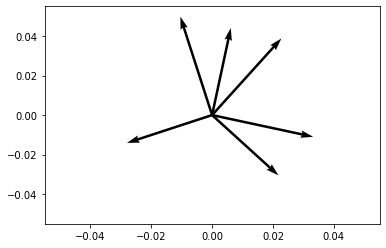

In [9]:
plt.quiver(*np.array([[0] * 6,[0] * 6]), pca.components_.T[:, 0], pca.components_.T[:, 1], scale=2)

### Сжатие других отведений

In [10]:
chest_leads = example[6:]
chest_leads.shape

(6, 1000)

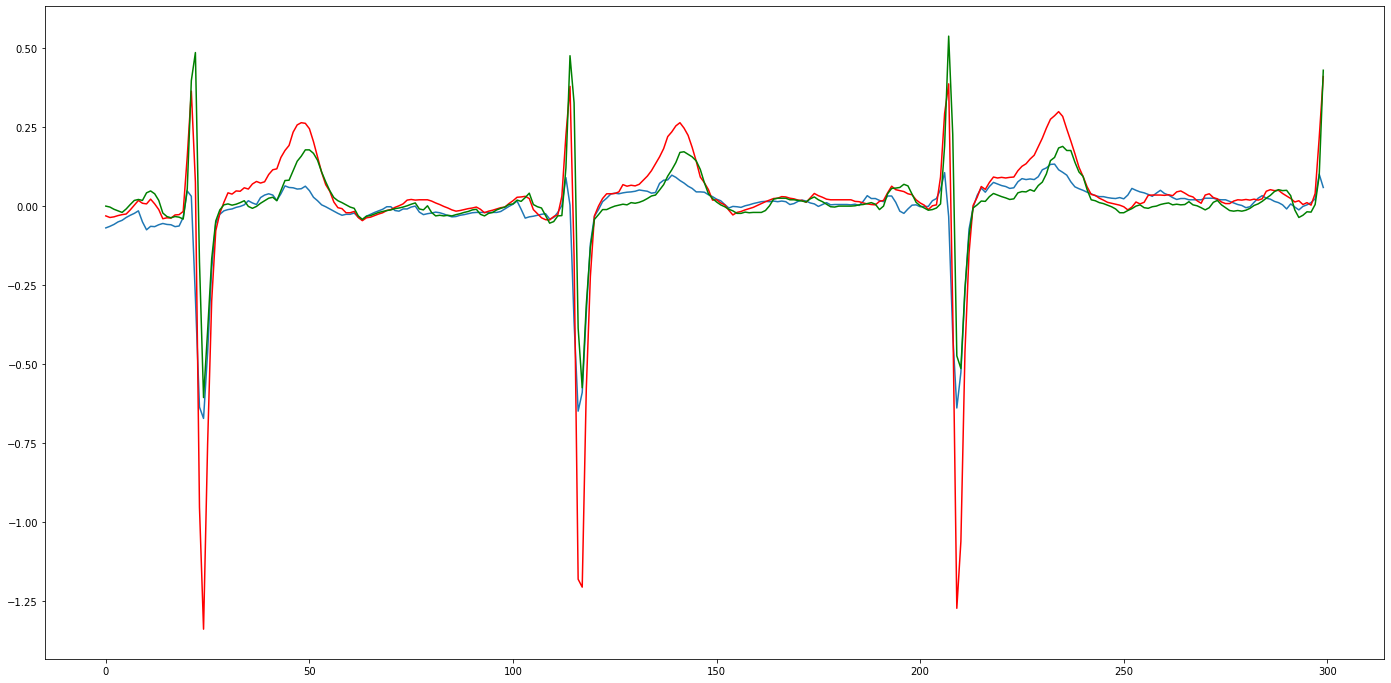

In [11]:
plt.figure(figsize=(24, 12))
plt.plot(chest_leads[0][:300])
plt.plot(chest_leads[1][:300], color='r')
plt.plot(chest_leads[2][:300], color='g')

In [12]:
for n_components in range(1, 6):
    chest_pca = PCA(n_components)
    chest_pca.fit(chest_leads.T)
    print(f'{n_components}-components PCA EVR: {np.sum(chest_pca.explained_variance_ratio_):.5f}')

1-components PCA EVR: 0.70241
2-components PCA EVR: 0.96361
3-components PCA EVR: 0.98904
4-components PCA EVR: 0.99553
5-components PCA EVR: 0.99841


In [13]:
def crosscorr(x, y, lag):
    return pd.Series(x).corr(pd.Series(y).shift(lag))

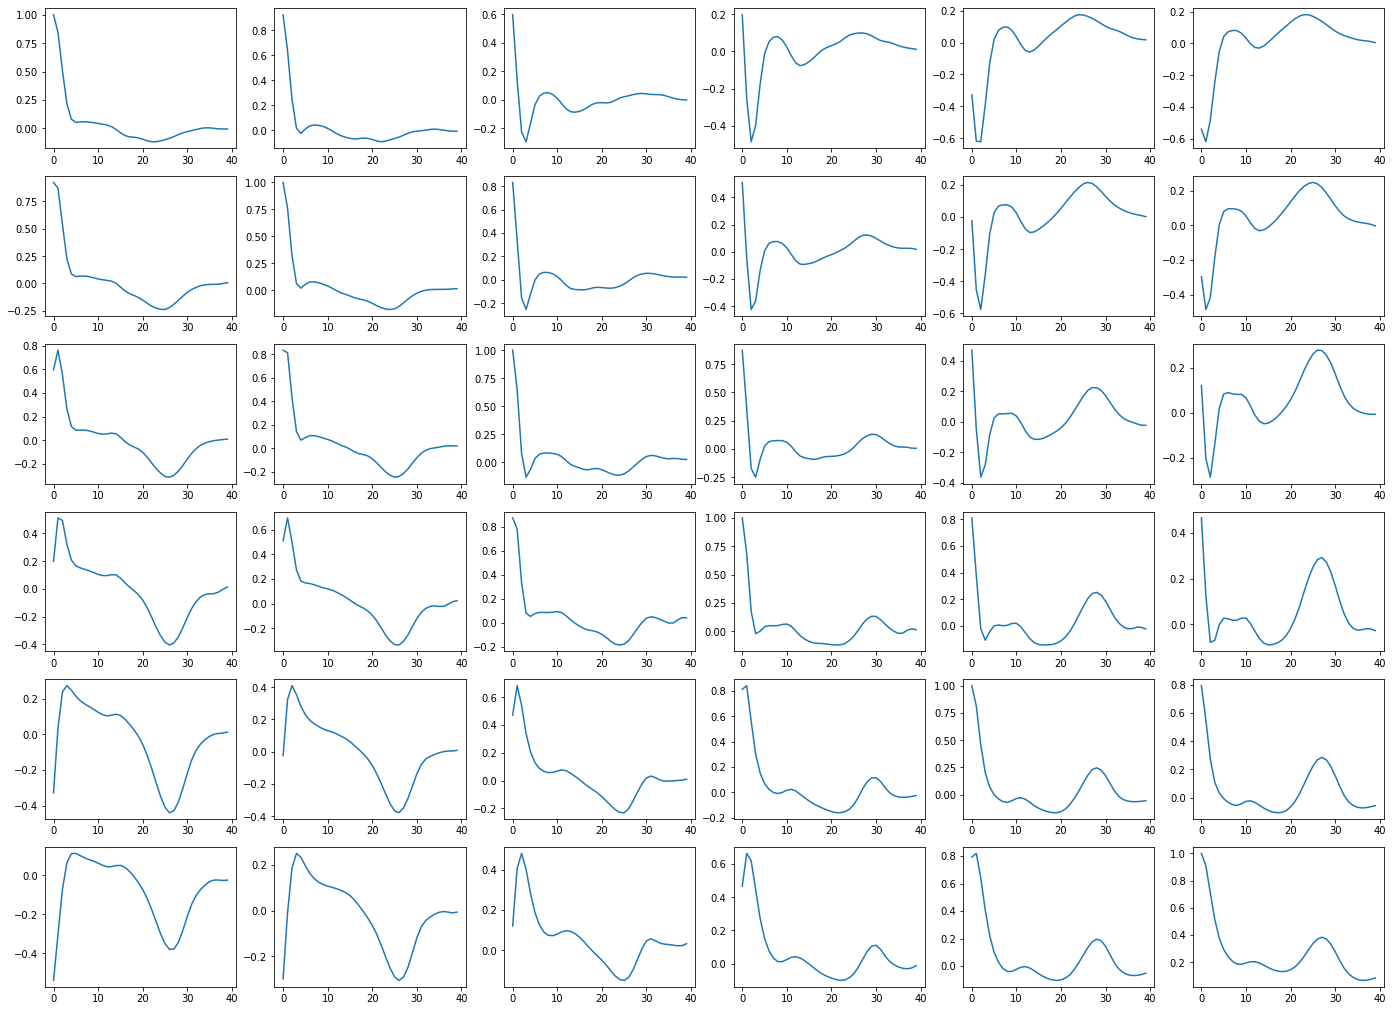

In [14]:
plt.figure(figsize=(24, 18))
for i in range(6):
    for j in range(6):
        ax = plt.subplot(6, 6, i * 6 + j + 1)
        corr = [crosscorr(chest_leads[i], chest_leads[j], lag) for lag in range(0, 40)]
        ax.plot(corr)

Как видно, грудные отведения линейно не зависимы а также уровень корелляции с лагом низок